[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.

Mean Best BLEU Score (max_tokens=200): 0.0268
Mean Best ROUGE-1 F Score (max_tokens=200): 0.5940
Mean Best BLEU Score (max_tokens=250): 0.0250
Mean Best ROUGE-1 F Score (max_tokens=250): 0.5623
Mean Best BLEU Score (max_tokens=300): 0.0276
Mean Best ROUGE-1 F Score (max_tokens=300): 0.5888
Mean Best BLEU Score (max_tokens=350): 0.0390
Mean Best ROUGE-1 F Score (max_tokens=350): 0.5842
Mean Best BLEU Score (max_tokens=450): 0.0286
Mean Best ROUGE-1 F Score (max_tokens=450): 0.5604
Mean Best BLEU Score (max_tokens=500): 0.0226
Mean Best ROUGE-1 F Score (max_tokens=500): 0.6010


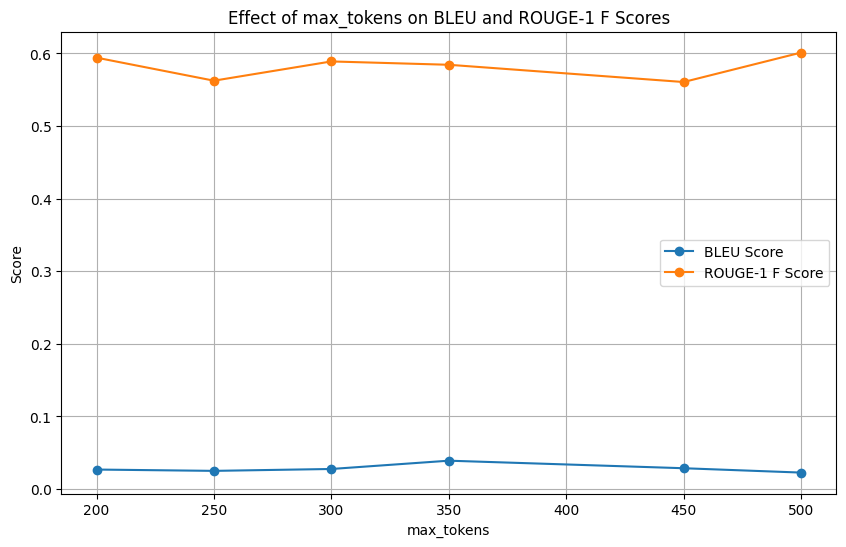

In [ ]:
##using 3 references
import openai
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

def remove_unwanted_words(text):
    unwanted_phrases = ["summary:", "the post", "the author"]
    # Iterate over each unwanted phrase and remove it from the text
    for phrase in unwanted_phrases:
        text = text.replace(phrase, "")
    return text.strip()


df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries_3.csv')

# Initialize lists to store scores for each max_tokens value
bleu_scores = []
rouge_1_f_scores = []

# Define max_tokens values to tune
max_tokens_values = [200, 250, 300, 350, 450,500]

# Loop through max_tokens values
for max_tokens in max_tokens_values:
    # Initialize variables to collect all best scores
    all_best_bleu = []
    all_best_rouge_1_f = []
    all_best_temperatures = []

    # Loop through data
    for index, row in df.iterrows():
        # Retrieve original post and reference summaries
        post = row["translated_text"].lower()  # Convert to lowercase
        reference_summary_1 = row["reference_summary_1"].lower()  # Convert to lowercase
        reference_summary_2 = row["reference_summary_2"].lower()  # Convert to lowercase
        reference_summary_3 = row["reference_summary_3"].lower()  # Convert to lowercase

        # Initialize variables for best scores in this row
        best_bleu = 0
        best_rouge = {'rouge-1': {'f': 0}, 'rouge-2': {'f': 0}, 'rouge-l': {'f': 0}}
        best_temperature = None

        # Loop through a range of temperature values
        for temp in [x * 0.1 for x in range(1, 10)]:
            response = openai.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature=temp,
                max_tokens=max_tokens,  # Set max_tokens
                messages=[{
                    "role": "system",
                    "content": "You are an expert assistant with expertise in summarizing posts."
                }, {
                    "role": "user",
                    "content": f"Please provide an abstractive summary of the following post and use 'I' as a subject for the summaries don't paraphrase use the same words exist in the post:\nTEXT: {post}"
                }]
            )

            generated_summary = response.choices[0].message.content.lower()  # Convert to lowercase
            generated_summary = remove_unwanted_words(generated_summary)
            reference_summaries = [reference_summary_1, reference_summary_2, reference_summary_3]
            reference_summaries_processed = [preprocess_text(ref_summary) for ref_summary in reference_summaries]
            generated_summary_processed = preprocess_text(generated_summary)


            # Calculate BLEU and ROUGE scores
            bleu_score = corpus_bleu([reference_summaries_processed],
                         [generated_summary_processed.split()], weights=(1, 0, 0, 0))
            rouge = Rouge()

# Join processed reference summaries into a single string
            reference_summaries_joined = " ".join(reference_summaries_processed)

            scores = rouge.get_scores(generated_summary_processed, reference_summaries_joined, avg=True)

            # Update best scores if current scores are better
            if bleu_score > best_bleu or scores['rouge-1']['f'] > best_rouge['rouge-1']['f']:
                best_bleu = bleu_score
                best_rouge = scores
                best_temperature = temp

        # Append best scores for this post to lists
        all_best_bleu.append(best_bleu)
        all_best_rouge_1_f.append(best_rouge['rouge-1']['f'])
        if best_temperature is not None:
            all_best_temperatures.append(best_temperature)

        # Append generated summary to the DataFrame
        df.at[index, "generated_summary"] = generated_summary

    # Calculate mean BLEU and ROUGE-1 F scores for this max_tokens value
    mean_bleu = sum(all_best_bleu) / len(all_best_bleu)
    mean_rouge_1_f = sum(all_best_rouge_1_f) / len(all_best_rouge_1_f)

    # Append mean scores to the respective lists
    bleu_scores.append(mean_bleu)
    rouge_1_f_scores.append(mean_rouge_1_f)

    print(f"Mean Best BLEU Score (max_tokens={max_tokens}): {mean_bleu:.4f}")
    print(f"Mean Best ROUGE-1 F Score (max_tokens={max_tokens}): {mean_rouge_1_f:.4f}")

# Plot the scores against the max_tokens values
plt.figure(figsize=(10, 6))
plt.plot(max_tokens_values, bleu_scores, marker='o', label='BLEU Score')
plt.plot(max_tokens_values, rouge_1_f_scores, marker='o', label='ROUGE-1 F Score')
plt.xlabel('max_tokens')
plt.ylabel('Score')
plt.title('Effect of max_tokens on BLEU and ROUGE-1 F Scores')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install openai

In [ ]:
!pip install rouge

In [ ]:
#!pip install meteor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
#df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries_3.csv')
df

,translated_text,is_depression,reference_summary_1,reference_summary_2,reference_summary_3
0,i m year old turning soon in a few month i liv...,1,"Approaching another year, I'm consumed by cons...","live in constant dread, no passion, no goals,o...","distress and loneliness, feelings of emptiness..."
1,tw suicide yea so my recent symptom of depress...,1,"Experiencing symptoms of depression, I've been...",feel very old despite my actual age. I have to...,I have symptoms of depression where I feel ver...
2,anyone else instead of sleeping more when depr...,1,"When depressed, instead of sleeping more, some...","when people are depressed, including me, I pre...",People prefer to stay awake all night to avoid...
3,i ve kind of stuffed around a lot in my life d...,1,I spent lot of time avoiding the inevitable re...,I was procrastinating working a job and becomi...,I was delayed from working a job and having an...
4,year have passed but the only thing that doesn...,1,"Years have gone by, yet the persistent feeling...",feeling of loneliness because I had a troubled...,feeling of loneliness because I had a troubled...
5,last november i had a week where i wa so scare...,1,"Last November, I experienced an intense fear o...",I experienced a week of intense fear of death ...,last november I experienced a week of intense ...
6,depression healed,1,depression healed,Overcoming depression,conquering depression
7,bridgetsbeaches thank you for letting people k...,0,Expressing gratitude to BridgetsBeaches for in...,bridgetsbeaches I am grateful for sharing the ...,Thanking BridgetsBeaches for sharing informati...
8,charlietm i know right i dunno what is going o...,0,I am confused want to know what happened with ...,Charlietm I am uncertain about the happenings ...,charlietm I feel perplexed by not knowing what...
9,argh i wa suuuper sleepy an hour ago now i m w...,0,"Feeling extremely sleepy an hour ago, now I'm ...",feeling extremely sleepy an hour ago but now b...,feeling extremely sleepy an hour ago but now b...


In [ ]:
OPENAI_API_KEY = " "


In [ ]:
import openai
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

df = pd.read_csv("your_dataset.csv")

best_bleu = 0
best_rouge = {'rouge-1': {'f': 0}, 'rouge-2': {'f': 0}, 'rouge-l': {'f': 0}}
best_temperature = None

for index, row in df.iterrows():
    # Retrieve original post and reference summary
    post = row["original_post"]
    reference_summary = row["reference_summary"]

    # Loop through a range of temperature values
    for temp in [x * 0.1 for x in range(1, 10)]:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            temperature=temp,
            max_tokens=256,
            messages=[{
                "role": "system",
                "content": "You are an expert assistant with expertise in summarizing posts."
            }, {
                "role": "user",
                "content": f'Please provide an abstractive summary of the following post without paraphrasing use the same words exist in the post:\nTEXT: {post}'
            }]
        )

        generated_summary = response.choices[0].message.content
        reference_summary_processed = preprocess_text(reference_summary)
        generated_summary_processed = preprocess_text(generated_summary)

        # Calculate BLEU and ROUGE scores
        bleu_score = corpus_bleu([[reference_summary_processed.split()]], [generated_summary_processed.split()])
        rouge = Rouge()
        scores = rouge.get_scores(generated_summary_processed, reference_summary_processed, avg=True)

        if bleu_score > best_bleu or scores['rouge-1']['f'] > best_rouge['rouge-1']['f']:
            best_bleu = bleu_score
            best_rouge = scores
            best_temperature = temp

        print(f"Index: {index}, Temperature: {temp}, Processed BLEU Score: {bleu_score}, Processed ROUGE-1 F-score: {scores['rouge-1']['f']}")

    print(f"Best scores for index {index}: BLEU={best_bleu}, ROUGE={best_rouge}, Temperature={best_temperature}")

    df.at[index, "generated_summary"] = generated_summary

df.to_csv("updated_dataset.csv", index=False)

In [ ]:
import openai
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

def remove_unwanted_words(text):
    unwanted_words = {'summary', 'post', 'author'}
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in unwanted_words]
    return ' '.join(filtered_words)

df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries.csv')

best_bleu = 0
best_rouge = {'rouge-1': {'f': 0}, 'rouge-2': {'f': 0}, 'rouge-l': {'f': 0}}
best_temperature = None

for index, row in df.iterrows():
    # Retrieve original post and reference summary
    post = row["translated_text"].lower()  # Convert to lowercase
    reference_summary = row["reference_summary"].lower()  # Convert to lowercase

    # Loop through a range of temperature values
    for temp in [x * 0.1 for x in range(1, 10)]:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=temp,
            max_tokens=256,
            messages=[{
                "role": "system",
                "content": "You are an expert assistant with expertise in summarizing posts."
            }, {
                "role": "user",
                "content": f"Please provide an abstractive summary of the following post without paraphrasing use the same words exist in the post and use 'I' as a subject:\nTEXT: {post}"
            }]
        )

        generated_summary = response.choices[0].message.content.lower()  # Convert to lowercase
        generated_summary = remove_unwanted_words(generated_summary)
        reference_summary_processed = preprocess_text(reference_summary)
        generated_summary_processed = preprocess_text(generated_summary)

        # Calculate BLEU and ROUGE scores
        bleu_score = corpus_bleu([[reference_summary_processed.split()]], [generated_summary_processed.split()])
        rouge = Rouge()
        scores = rouge.get_scores(generated_summary_processed, reference_summary_processed, avg=True)

        # Update best scores if current scores are better
        if bleu_score > best_bleu or scores['rouge-1']['f'] > best_rouge['rouge-1']['f']:
            best_bleu = bleu_score
            best_rouge = scores
            best_temperature = temp

        print(f"Index: {index}, Temperature: {temp}, Processed BLEU Score: {bleu_score}, Processed ROUGE-1 F-score: {scores['rouge-1']['f']}")

    print(f"Best scores for index {index}: BLEU={best_bleu}, ROUGE={best_rouge}, Temperature={best_temperature}")

    # Append generated summary to the DataFrame
    df.at[index, "generated_summary"] = generated_summary

# Save DataFrame with generated summaries to CSV
df.to_csv("updated_dataset.csv", index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Index: 0, Temperature: 0.1, Processed BLEU Score: 0.07076879689294892, Processed ROUGE-1 F-score: 0.358381498432958
Index: 0, Temperature: 0.2, Processed BLEU Score: 0.05588537843519099, Processed ROUGE-1 F-score: 0.34883720483234176
Index: 0, Temperature: 0.30000000000000004, Processed BLEU Score: 0.07106677736429817, Processed ROUGE-1 F-score: 0.358381498432958
Index: 0, Temperature: 0.4, Processed BLEU Score: 0.058228710596281236, Processed ROUGE-1 F-score: 0.35502958129057116
Index: 0, Temperature: 0.5, Processed BLEU Score: 0.08915482815488904, Processed ROUGE-1 F-score: 0.424999995378125
Index: 0, Temperature: 0.6000000000000001, Processed BLEU Score: 0.05588537843519099, Processed ROUGE-1 F-score: 0.34883720483234176
Index: 0, Temperature: 0.7000000000000001, Processed BLEU Score: 0.10292110634981641, Processed ROUGE-1 F-score: 0.47482013902178977
Index: 0, Temperature: 0.8, Processed BLEU Score: 0.14623426078005813, Processed ROUGE-1 F-score: 0.4761904712219703
Index: 0, Temper

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Index: 1, Temperature: 0.1, Processed BLEU Score: 2.821537089831835e-78, Processed ROUGE-1 F-score: 0.5106382928927117
Index: 1, Temperature: 0.2, Processed BLEU Score: 2.857363507197355e-78, Processed ROUGE-1 F-score: 0.4891304297920605
Index: 1, Temperature: 0.30000000000000004, Processed BLEU Score: 2.831083994295694e-78, Processed ROUGE-1 F-score: 0.4919786046429695
Index: 1, Temperature: 0.4, Processed BLEU Score: 2.9991827834817735e-78, Processed ROUGE-1 F-score: 0.5164835114889507
Index: 1, Temperature: 0.5, Processed BLEU Score: 0.09372750616185468, Processed ROUGE-1 F-score: 0.5326086906616257
Index: 1, Temperature: 0.6000000000000001, Processed BLEU Score: 3.065102423558993e-78, Processed ROUGE-1 F-score: 0.4999999950024692
Index: 1, Temperature: 0.7000000000000001, Processed BLEU Score: 0.14876982216079992, Processed ROUGE-1 F-score: 0.5294117597121109
Index: 1, Temperature: 0.8, Processed BLEU Score: 0.13424180728388826, Processed ROUGE-1 F-score: 0.5139664754483318
Index: 

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Index: 6, Temperature: 0.1, Processed BLEU Score: 1.5319719891192393e-231, Processed ROUGE-1 F-score: 0.7999999952000001
Index: 6, Temperature: 0.2, Processed BLEU Score: 1.4488496539373276e-231, Processed ROUGE-1 F-score: 0.6666666622222223
Index: 6, Temperature: 0.30000000000000004, Processed BLEU Score: 1.5319719891192393e-231, Processed ROUGE-1 F-score: 0.7999999952000001
Index: 6, Temperature: 0.4, Processed BLEU Score: 1.5319719891192393e-231, Processed ROUGE-1 F-score: 0.7999999952000001
Index: 6, Temperature: 0.5, Processed BLEU Score: 1.5319719891192393e-231, Processed ROUGE-1 F-score: 0.7999999952000001
Index: 6, Temperature: 0.6000000000000001, Processed BLEU Score: 1.4488496539373276e-231, Processed ROUGE-1 F-score: 0.6666666622222223
Index: 6, Temperature: 0.7000000000000001, Processed BLEU Score: 1.5319719891192393e-231, Processed ROUGE-1 F-score: 0.7999999952000001
Index: 6, Temperature: 0.8, Processed BLEU Score: 1.5319719891192393e-231, Processed ROUGE-1 F-score: 0.799

In [ ]:
# withou hypertuning max tokens

import openai
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

def remove_unwanted_words(text):
    # Define unwanted words and phrases
    unwanted_phrases = ["summary:", "the post", "the author"]
    # Iterate over each unwanted phrase and remove it from the text
    for phrase in unwanted_phrases:
        text = text.replace(phrase, "")
    return text.strip()

df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries.csv')

all_best_bleu = []
all_best_rouge_1_f = []
all_best_temperatures = []

# Loop through data
for index, row in df.iterrows():
    # Retrieve original post and reference summary
    post = row["translated_text"].lower()
    reference_summary = row["reference_summary"].lower()

    best_bleu = 0
    best_rouge = {'rouge-1': {'f': 0}, 'rouge-2': {'f': 0}, 'rouge-l': {'f': 0}}
    best_temperature = None

    # Loop through a range of temperature values
    for temp in [x * 0.1 for x in range(1, 10)]:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=temp,
            max_tokens=256,
            messages=[{
                "role": "system",
                "content": "You are an expert assistant with expertise in summarizing posts."
            }, {
                "role": "user",
                "content": f"Please provide an abstractive summary of the following post and use 'I' as a subject for the summaries don't paraphrase use the same words exist in the post:\nTEXT: {post}"
            }]
        )

        generated_summary = response.choices[0].message.content.lower()  # Convert to lowercase
        generated_summary = remove_unwanted_words(generated_summary)
        reference_summary_processed = preprocess_text(reference_summary)
        generated_summary_processed = preprocess_text(generated_summary)

        bleu_score = corpus_bleu([[reference_summary_processed.split()]],
                                 [generated_summary_processed.split()],weights=(1, 0, 0, 0))
        rouge = Rouge()
        scores = rouge.get_scores(generated_summary_processed, reference_summary_processed, avg=True)

        # Update best scores if current scores are better
        if bleu_score > best_bleu or scores['rouge-1']['f'] > best_rouge['rouge-1']['f']:
            best_bleu = bleu_score
            best_rouge = scores
            best_temperature = temp

    # Append best scores for this post to lists
    all_best_bleu.append(best_bleu)
    all_best_rouge_1_f.append(best_rouge['rouge-1']['f'])
    if best_temperature is not None:
        all_best_temperatures.append(best_temperature)

    # Append generated summary to the DataFrame
    df.at[index, "generated_summary"] = generated_summary

df.to_csv("updated_dataset.csv", index=False)

# Calculate means of best scores
mean_bleu = sum(all_best_bleu) / len(all_best_bleu)
mean_rouge_1_f = sum(all_best_rouge_1_f) / len(all_best_rouge_1_f)
mean_temperature = sum(all_best_temperatures) / len(all_best_temperatures)

print(f"Mean Best BLEU Score: {mean_bleu:.4f}")
print(f"Mean Best ROUGE-1 F Score: {mean_rouge_1_f:.4f}")
print(f"Mean Best Temperature: {mean_temperature:.2f}")
#Mean Best BLEU Score: 0.5576
#Mean Best ROUGE-1 F Score: 0.5958
#Mean Best Temperature: 0.64

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.

Mean Best BLEU Score: 0.5576
Mean Best ROUGE-1 F Score: 0.5958
Mean Best Temperature: 0.64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Scores for max_tokens=200:


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

  Temperature=0.0, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.1, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.2, BLEU=0.6667, ROUGE-1 F=0.7500
  Temperature=0.3, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.4, BLEU=0.7407, ROUGE-1 F=0.7907
  Temperature=0.5, BLEU=0.7143, ROUGE-1 F=0.8293
  Temperature=0.6, BLEU=0.7041, ROUGE-1 F=0.8000
  Temperature=0.7, BLEU=0.8000, ROUGE-1 F=0.7500
  Temperature=0.8, BLEU=0.8000, ROUGE-1 F=0.7500
  Temperature=0.9, BLEU=0.7407, ROUGE-1 F=0.7907
  Temperature=1.0, BLEU=0.8000, ROUGE-1 F=0.7500


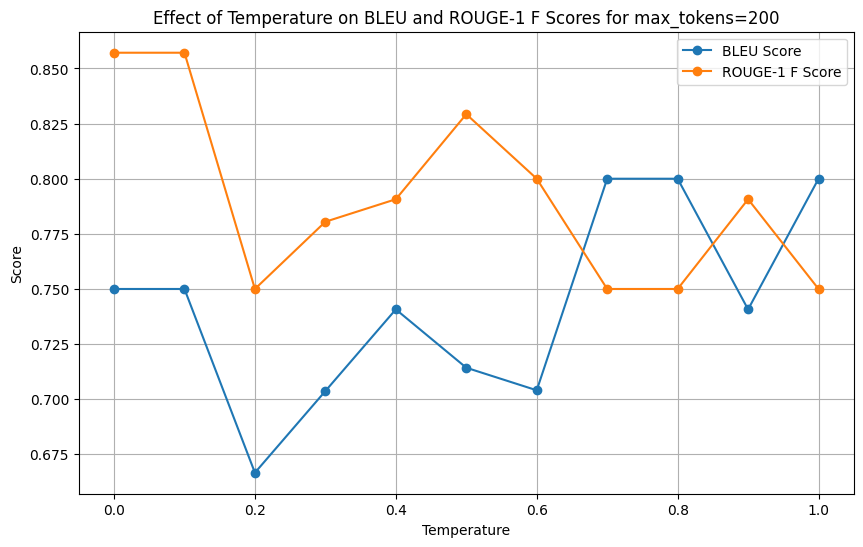

Scores for max_tokens=250:
  Temperature=0.0, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.1, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.2, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.3, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.4, BLEU=0.8333, ROUGE-1 F=0.8571
  Temperature=0.5, BLEU=0.7407, ROUGE-1 F=0.7907
  Temperature=0.6, BLEU=0.7143, ROUGE-1 F=0.8293
  Temperature=0.7, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.8, BLEU=0.8000, ROUGE-1 F=0.7500
  Temperature=0.9, BLEU=0.7826, ROUGE-1 F=0.7945
  Temperature=1.0, BLEU=0.6667, ROUGE-1 F=0.7317


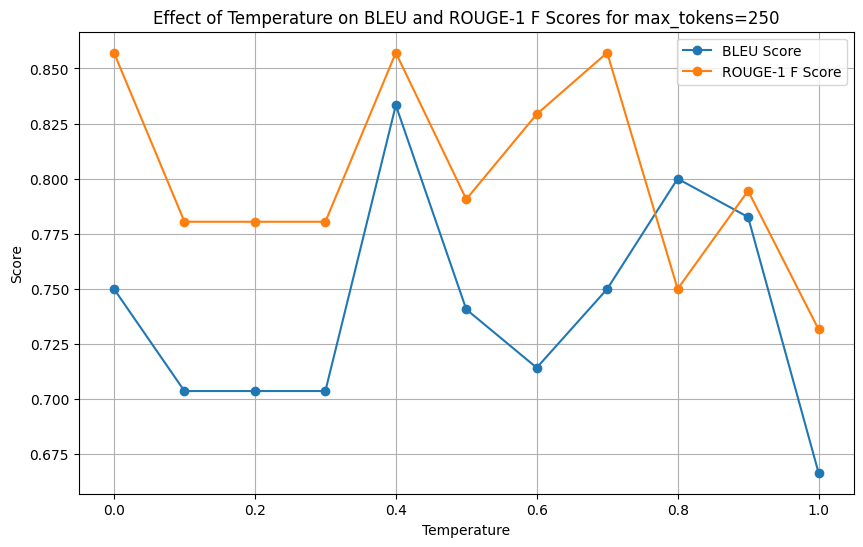

Scores for max_tokens=300:
  Temperature=0.0, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.1, BLEU=0.6815, ROUGE-1 F=0.7647
  Temperature=0.2, BLEU=0.7143, ROUGE-1 F=0.8293
  Temperature=0.3, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.4, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.5, BLEU=0.7143, ROUGE-1 F=0.8293
  Temperature=0.6, BLEU=0.6923, ROUGE-1 F=0.7500
  Temperature=0.7, BLEU=0.6872, ROUGE-1 F=0.7714
  Temperature=0.8, BLEU=0.6429, ROUGE-1 F=0.7500
  Temperature=0.9, BLEU=0.7600, ROUGE-1 F=0.7805
  Temperature=1.0, BLEU=0.6552, ROUGE-1 F=0.7442


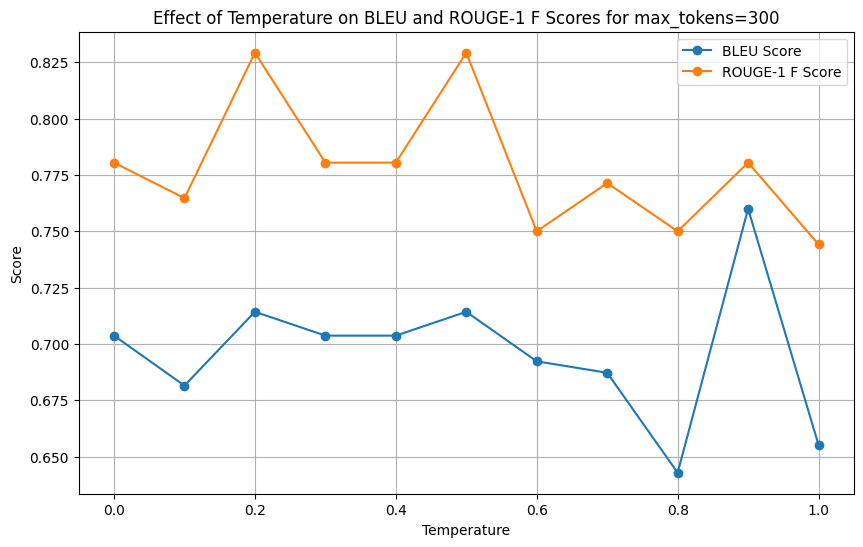

Scores for max_tokens=350:
  Temperature=0.0, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.1, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.2, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.3, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.4, BLEU=0.8144, ROUGE-1 F=0.8421
  Temperature=0.5, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.6, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.7, BLEU=0.6786, ROUGE-1 F=0.7805
  Temperature=0.8, BLEU=0.6818, ROUGE-1 F=0.6842
  Temperature=0.9, BLEU=0.6923, ROUGE-1 F=0.7179
  Temperature=1.0, BLEU=0.7315, ROUGE-1 F=0.8000


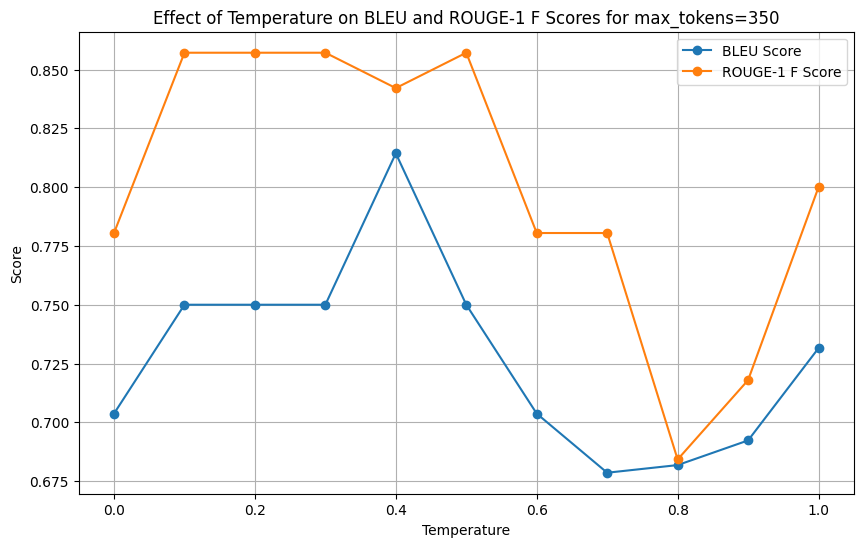

Scores for max_tokens=450:
  Temperature=0.0, BLEU=0.6296, ROUGE-1 F=0.7000
  Temperature=0.1, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.2, BLEU=0.7037, ROUGE-1 F=0.7805
  Temperature=0.3, BLEU=0.7143, ROUGE-1 F=0.8293
  Temperature=0.4, BLEU=0.6800, ROUGE-1 F=0.7692
  Temperature=0.5, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.6, BLEU=0.6538, ROUGE-1 F=0.7000
  Temperature=0.7, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.8, BLEU=0.6897, ROUGE-1 F=0.7907
  Temperature=0.9, BLEU=0.6794, ROUGE-1 F=0.7179
  Temperature=1.0, BLEU=0.6667, ROUGE-1 F=0.7317


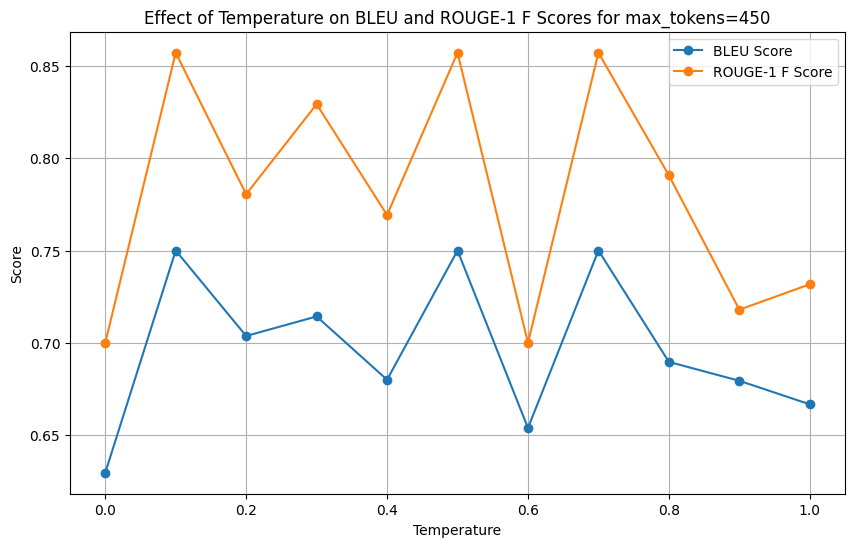

Scores for max_tokens=500:
  Temperature=0.0, BLEU=0.6815, ROUGE-1 F=0.7647
  Temperature=0.1, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.2, BLEU=0.6667, ROUGE-1 F=0.7317
  Temperature=0.3, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.4, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.5, BLEU=0.7500, ROUGE-1 F=0.8571
  Temperature=0.6, BLEU=0.7143, ROUGE-1 F=0.7727
  Temperature=0.7, BLEU=0.7109, ROUGE-1 F=0.7606
  Temperature=0.8, BLEU=0.6552, ROUGE-1 F=0.7619
  Temperature=0.9, BLEU=0.7104, ROUGE-1 F=0.7429
  Temperature=1.0, BLEU=0.7060, ROUGE-1 F=0.7826


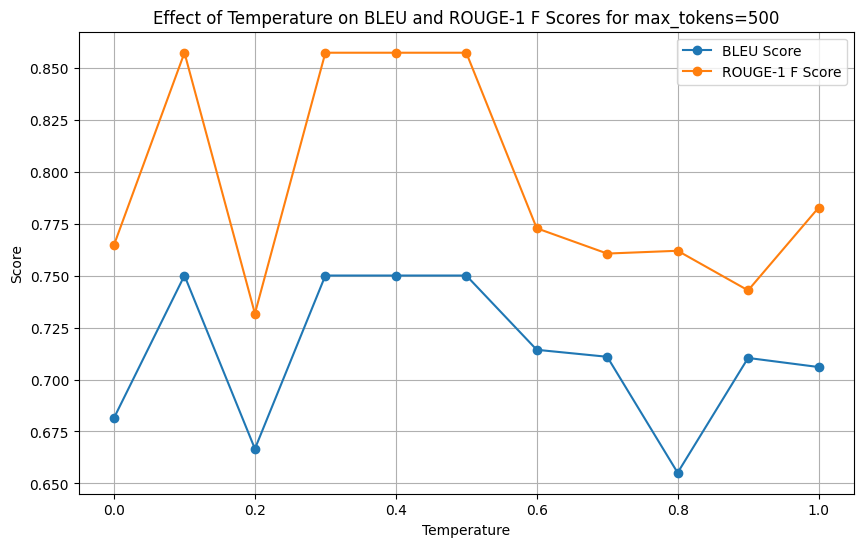

In [ ]:
import openai
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

def remove_unwanted_words(text):
    unwanted_phrases = ["summary:", "the post", "the author"]
    # Iterate over each unwanted phrase and remove it from the text
    for phrase in unwanted_phrases:
        text = text.replace(phrase, "")
    return text.strip()

df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries_1.csv')

max_tokens_values = [200, 250, 300, 350, 450, 500]

for max_tokens in max_tokens_values:
    bleu_scores = []
    rouge_1_f_scores = []

    all_best_bleu = []
    all_best_rouge_1_f = []
    all_best_temperatures = []

    print(f"Scores for max_tokens={max_tokens}:")
    for temp in [x * 0.1 for x in range(0, 11)]:
        best_bleu = 0
        best_rouge = {'rouge-1': {'f': 0}, 'rouge-2': {'f': 0}, 'rouge-l': {'f': 0}}
        best_generated_summary = ""

        for index, row in df.iterrows():
            # Retrieve original post and reference summary
            post = row["translated_text"].lower()
            reference_summary = row["reference_summary"].lower()

            response = openai.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature=temp,
                max_tokens=max_tokens,
                messages=[{
                    "role": "system",
                    "content": "You are an expert assistant with expertise in summarizing posts."
                }, {
                    "role": "user",
                    "content": f"Please provide an abstractive summary of the following post and use 'I' as a subject for the summaries don't paraphrase use the same words exist in the post:\nTEXT: {post}"
                }]
            )

            generated_summary = response.choices[0].message.content.lower()  # Convert to lowercase
            generated_summary = remove_unwanted_words(generated_summary)
            reference_summary_processed = preprocess_text(reference_summary)
            generated_summary_processed = preprocess_text(generated_summary)

            # Calculate BLEU and ROUGE scores
            bleu_score = corpus_bleu([[reference_summary_processed.split()]],
                                     [generated_summary_processed.split()], weights=(1, 0, 0, 0))
            rouge = Rouge()
            scores = rouge.get_scores(generated_summary_processed, reference_summary_processed, avg=True)

            # Update best scores if current scores are better
            if bleu_score > best_bleu or scores['rouge-1']['f'] > best_rouge['rouge-1']['f']:
                best_bleu = bleu_score
                best_rouge = scores
                best_generated_summary = generated_summary

        # Append best scores for this temperature to lists
        all_best_bleu.append(best_bleu)
        all_best_rouge_1_f.append(best_rouge['rouge-1']['f'])
        all_best_temperatures.append(temp)

        print(f"  Temperature={temp:.1f}, BLEU={best_bleu:.4f}, ROUGE-1 F={best_rouge['rouge-1']['f']:.4f}")

    # Plot the scores against the temperature values for this max_tokens value
    plt.figure(figsize=(10, 6))
    plt.plot(all_best_temperatures, all_best_bleu, marker='o', label='BLEU Score')
    plt.plot(all_best_temperatures, all_best_rouge_1_f, marker='o', label='ROUGE-1 F Score')
    plt.xlabel('Temperature')
    plt.ylabel('Score')
    plt.title(f'Effect of Temperature on BLEU and ROUGE-1 F Scores for max_tokens={max_tokens}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"max_tokens_{max_tokens}_scores.png")  # Save plot as PNG with max_tokens value in the filename
    plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.

Mean Best BLEU Score (max_tokens=200): 0.6392
Mean Best ROUGE-1 F Score (max_tokens=200): 0.7166
Mean Best BLEU Score (max_tokens=250): 0.6573
Mean Best ROUGE-1 F Score (max_tokens=250): 0.7242
Mean Best BLEU Score (max_tokens=300): 0.6578
Mean Best ROUGE-1 F Score (max_tokens=300): 0.7243
Mean Best BLEU Score (max_tokens=350): 0.6630
Mean Best ROUGE-1 F Score (max_tokens=350): 0.7290
Mean Best BLEU Score (max_tokens=450): 0.6471
Mean Best ROUGE-1 F Score (max_tokens=450): 0.7169
Mean Best BLEU Score (max_tokens=500): 0.6479
Mean Best ROUGE-1 F Score (max_tokens=500): 0.7171


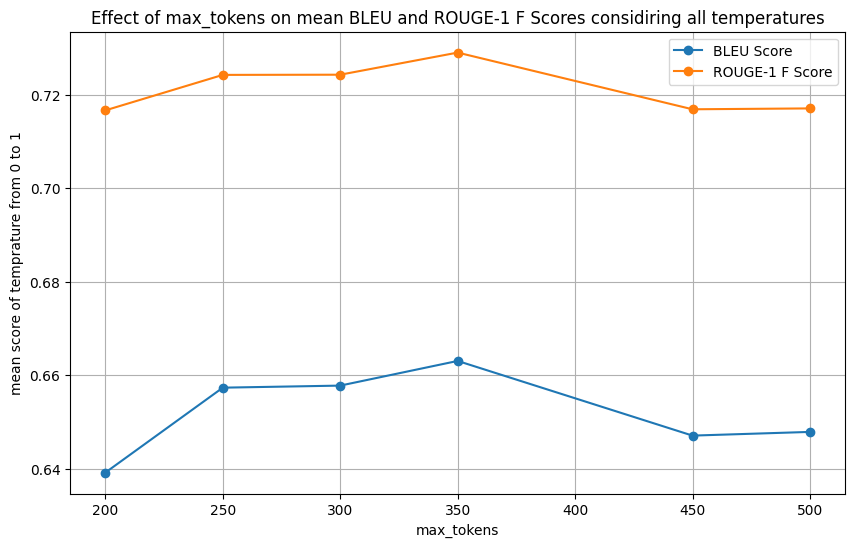

In [ ]:
# without info about which temperature applied
import openai
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

# Ensure necessary NLTK downloads
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

def remove_unwanted_words(text):
    unwanted_phrases = ["summary:", "the post", "the author"]
    for phrase in unwanted_phrases:
        text = text.replace(phrase, "")
    return text.strip()

df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries_1.csv')

bleu_scores = []
rouge_1_f_scores = []

max_tokens_values = [200, 250, 300, 350, 450,500]

for max_tokens in max_tokens_values:
    all_best_bleu = []
    all_best_rouge_1_f = []
    all_best_temperatures = []

    for index, row in df.iterrows():
        # Retrieve original post and reference summary
        post = row["translated_text"].lower()  # Convert to lowercase
        reference_summary = row["reference_summary"].lower()  # Convert to lowercase

        best_bleu = 0
        best_rouge = {'rouge-1': {'f': 0}, 'rouge-2': {'f': 0}, 'rouge-l': {'f': 0}}
        best_temperature = None

        # Loop through a range of temperature values
        for temp in [x * 0.1 for x in range(0, 11)]:
            response = openai.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature=temp,
                max_tokens=max_tokens,  # Set max_tokens
                messages=[{
                    "role": "system",
                    "content": "You are an expert assistant with expertise in summarizing posts."
                }, {
                    "role": "user",
                    "content": f"Please provide an abstractive summary of the following post and use 'I' as a subject for the summaries don't paraphrase use the same words exist in the post:\nTEXT: {post}"
                }]
            )

            generated_summary = response.choices[0].message.content.lower()
            generated_summary = remove_unwanted_words(generated_summary)
            reference_summary_processed = preprocess_text(reference_summary)
            generated_summary_processed = preprocess_text(generated_summary)

            # Calculate BLEU and ROUGE scores
            bleu_score = corpus_bleu([[reference_summary_processed.split()]],
                                     [generated_summary_processed.split()],weights=(1, 0, 0, 0))
            rouge = Rouge()
            scores = rouge.get_scores(generated_summary_processed, reference_summary_processed, avg=True)

            # Update best scores if current scores are better
            if bleu_score > best_bleu or scores['rouge-1']['f'] > best_rouge['rouge-1']['f']:
                best_bleu = bleu_score
                best_rouge = scores
                best_temperature = temp

        # Append best scores for this post to lists
        all_best_bleu.append(best_bleu)
        all_best_rouge_1_f.append(best_rouge['rouge-1']['f'])
        if best_temperature is not None:
            all_best_temperatures.append(best_temperature)

        # Append generated summary to the DataFrame
        df.at[index, "generated_summary"] = generated_summary

    # Calculate mean BLEU and ROUGE-1 F scores for this max_tokens value
    mean_bleu = sum(all_best_bleu) / len(all_best_bleu)
    mean_rouge_1_f = sum(all_best_rouge_1_f) / len(all_best_rouge_1_f)

    # Append mean scores to the respective lists
    bleu_scores.append(mean_bleu)
    rouge_1_f_scores.append(mean_rouge_1_f)

    print(f"Mean Best BLEU Score (max_tokens={max_tokens}): {mean_bleu:.4f}")
    print(f"Mean Best ROUGE-1 F Score (max_tokens={max_tokens}): {mean_rouge_1_f:.4f}")

# Plot the scores against the max_tokens values
plt.figure(figsize=(10, 6))
plt.plot(max_tokens_values, bleu_scores, marker='o', label='BLEU Score')
plt.plot(max_tokens_values, rouge_1_f_scores, marker='o', label='ROUGE-1 F Score')
plt.xlabel('max_tokens')
plt.ylabel('mean score of temprature from 0 to 1')
plt.title('Effect of max_tokens on mean BLEU and ROUGE-1 F Scores considiring all temperatures')
plt.legend()
plt.grid(True)
plt.savefig(f"Effect of max_tokens on mean BLEU and ROUGE-1 F Scores considiring all temperatures.png")  # Save plot as PNG with max_tokens value in the filename
plt.show()
#based on it we consider the best is 350 token

In [ ]:
#storing score of different token in csv file
import openai
import os
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

if 'OPENAI_API_KEY' in os.environ:
    openai.api_key = os.environ['OPENAI_API_KEY']
else:

    openai.api_key = OPENAI_API_KEY


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

def remove_unwanted_words(text):
    unwanted_phrases = ["summary:", "the post", "the author"]
    for phrase in unwanted_phrases:
        text = text.replace(phrase, "")
    return text.strip()

df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries_1.csv')

output_dir = '/content/drive/My Drive/Master_Thesis/summary_scores/'

os.makedirs(output_dir, exist_ok=True)

max_tokens_values = [200, 250, 300, 350, 450, 500]

for max_tokens in max_tokens_values:
    scores_list = []

    for temp in [x * 0.1 for x in range(0, 11)]:
        best_bleu = 0
        best_rouge = {'rouge-1': {'f': 0}, 'rouge-2': {'f': 0}, 'rouge-l': {'f': 0}}
        best_generated_summary = ""

        for index, row in df.iterrows():
            # Retrieve original post and reference summary
            post = row["translated_text"].lower()  # Convert to lowercase
            reference_summary = row["reference_summary"].lower()  # Convert to lowercase

            response = openai.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature=temp,
                max_tokens=max_tokens,  # Set max_tokens
                messages=[{
                    "role": "system",
                    "content": "You are an expert assistant with expertise in summarizing posts."
                }, {
                    "role": "user",
                    "content": f"Please provide an abstractive summary of the following post and use 'I' as a subject for the summaries don't paraphrase use the same words exist in the post:\nTEXT: {post}"
                }]
            )

            generated_summary = response.choices[0].message.content.lower()  # Convert to lowercase
            generated_summary = remove_unwanted_words(generated_summary)
            reference_summary_processed = preprocess_text(reference_summary)
            generated_summary_processed = preprocess_text(generated_summary)

            # Calculate BLEU and ROUGE scores
            bleu_score = corpus_bleu([[reference_summary_processed.split()]],
                                     [generated_summary_processed.split()], weights=(1, 0, 0, 0))
            rouge = Rouge()
            scores = rouge.get_scores(generated_summary_processed, reference_summary_processed, avg=True)

            # Update best scores if current scores are better
            if bleu_score > best_bleu or scores['rouge-1']['f'] > best_rouge['rouge-1']['f']:
                best_bleu = bleu_score
                best_rouge = scores
                best_generated_summary = generated_summary

        # Append best scores for this temperature to the list
        scores_list.append({'Temperature': temp,
                            'BLEU': best_bleu,
                            'ROUGE-1 F': best_rouge['rouge-1']['f']})

    df_scores = pd.DataFrame(scores_list)

    # Calculate mean BLEU and ROUGE-1 F scores
    mean_bleu = df_scores['BLEU'].mean()
    mean_rouge_1_f = df_scores['ROUGE-1 F'].mean()

    # Append mean scores to the DataFrame
    df_scores.loc[df_scores.shape[0]] = ['Mean', mean_bleu, mean_rouge_1_f]

    # Write DataFrame to CSV with file name indicating max_tokens value
    output_file = os.path.join(output_dir, f'summary_scores_max_tokens_{max_tokens}.csv')
    df_scores.to_csv(output_file, index=False)

print("Processing complete. Summary scores saved in CSV format.")

In [ ]:
import openai
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

def remove_unwanted_words(text):
    unwanted_phrases = ["summary:", "the post", "the author"]
    for phrase in unwanted_phrases:
        text = text.replace(phrase, "")
    return text.strip()

df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries_1.csv')

bleu_scores = {temp: [] for temp in range(1, 10)}
rouge_1_f_scores = {temp: [] for temp in range(1, 10)}

max_tokens_values = [200, 250, 300, 350, 450, 500]

for max_tokens in max_tokens_values:
    all_best_bleu = {temp: [] for temp in range(1, 10)}
    all_best_rouge_1_f = {temp: [] for temp in range(1, 10)}

    for index, row in df.iterrows():
        # Retrieve original post and reference summary
        post = row["translated_text"].lower()  # Convert to lowercase
        reference_summary = row["reference_summary"].lower()  # Convert to lowercase

        for temp in range(1, 10):
            response = openai.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature=temp * 0.1,
                max_tokens=max_tokens,  # Set max_tokens
                messages=[{
                    "role": "system",
                    "content": "You are an expert assistant with expertise in summarizing posts."
                }, {
                    "role": "user",
                    "content": f"Please provide an abstractive summary of the following post and use 'I' as a subject for the summaries don't paraphrase use the same words exist in the post:\nTEXT: {post}"
                }]
            )

            generated_summary = response.choices[0].message.content.lower()  # Convert to lowercase
            generated_summary = remove_unwanted_words(generated_summary)
            reference_summary_processed = preprocess_text(reference_summary)
            generated_summary_processed = preprocess_text(generated_summary)

            bleu_score = corpus_bleu([[reference_summary_processed.split()]],
                                     [generated_summary_processed.split()], weights=(1, 0, 0, 0))
            rouge = Rouge()
            scores = rouge.get_scores(generated_summary_processed, reference_summary_processed, avg=True)

            # Append scores for this temperature to lists
            all_best_bleu[temp].append(bleu_score)
            all_best_rouge_1_f[temp].append(scores['rouge-1']['f'])

    for temp in range(1, 10):
        mean_bleu = sum(all_best_bleu[temp]) / len(all_best_bleu[temp])
        mean_rouge_1_f = sum(all_best_rouge_1_f[temp]) / len(all_best_rouge_1_f[temp])
        bleu_scores[temp].append(mean_bleu)
        rouge_1_f_scores[temp].append(mean_rouge_1_f)

plt.figure(figsize=(10, 6))
for temp in range(1, 10):
    plt.plot(max_tokens_values, bleu_scores[temp], marker='o', label=f'BLEU Score (Temp: {temp * 0.1})')
    plt.plot(max_tokens_values, rouge_1_f_scores[temp], marker='o', label=f'ROUGE-1 F Score (Temp: {temp * 0.1})')
plt.xlabel('max_tokens')
plt.ylabel('Score')
plt.title('Effect of max_tokens on BLEU and ROUGE-1 F Scores for Different Temperatures')
plt.legend()
plt.grid(True)
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.

KeyboardInterrupt: 

In [ ]:
###Plot the scores against the temperature values for this max_tokens working

import openai
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])

def remove_unwanted_words(text):
    unwanted_phrases = ["summary:", "the post", "the author"]
    for phrase in unwanted_phrases:
        text = text.replace(phrase, "")
    return text.strip()

df = pd.read_csv('/content/drive/My Drive/Master_Thesis/reference_summaries.csv')

max_tokens_values = [200, 250, 300, 350, 450, 500]

for max_tokens in max_tokens_values:
    temperatures = []
    bleu_scores = []
    rouge_1_f_scores = []

    for temp in [x * 0.1 for x in range(1, 10)]:
        all_best_bleu = []
        all_best_rouge_1_f = []

        for index, row in df.iterrows():
            post = row["translated_text"].lower()  # Convert to lowercase
            reference_summary = row["reference_summary"].lower()  # Convert to lowercase

            # Initialize variables for best scores in this row
            best_bleu = 0
            best_rouge = {'rouge-1': {'f': 0}, 'rouge-2': {'f': 0}, 'rouge-l': {'f': 0}}
            best_temperature = None

            response = openai.chat.completions.create(
                model="gpt-3.5-turbo",
                temperature=temp,
                max_tokens=max_tokens,
                messages=[{
                    "role": "system",
                    "content": "You are an expert assistant with expertise in summarizing posts."
                }, {
                    "role": "user",
                    "content": f"Please provide an abstractive summary of the following post and use 'I' as a subject for the summaries don't paraphrase use the same words exist in the post:\nTEXT: {post}"
                }]
            )

            generated_summary = response.choices[0].message.content.lower()  # Convert to lowercase
            generated_summary = remove_unwanted_words(generated_summary)
            reference_summary_processed = preprocess_text(reference_summary)
            generated_summary_processed = preprocess_text(generated_summary)

            bleu_score = corpus_bleu([[reference_summary_processed.split()]],
                                     [generated_summary_processed.split()], weights=(1, 0, 0, 0))
            rouge = Rouge()
            scores = rouge.get_scores(generated_summary_processed, reference_summary_processed, avg=True)

            # Update best scores if current scores are better
            if bleu_score > best_bleu or scores['rouge-1']['f'] > best_rouge['rouge-1']['f']:
                best_bleu = bleu_score
                best_rouge = scores
                best_temperature = temp

            # Append best scores for this post to lists
            all_best_bleu.append(best_bleu)
            all_best_rouge_1_f.append(best_rouge['rouge-1']['f'])

        # Calculate mean BLEU and ROUGE-1 F scores for this temperature value
        mean_bleu = sum(all_best_bleu) / len(all_best_bleu)
        mean_rouge_1_f = sum(all_best_rouge_1_f) / len(all_best_rouge_1_f)

        # Append temperature and mean scores to lists
        temperatures.append(temp)
        bleu_scores.append(mean_bleu)
        rouge_1_f_scores.append(mean_rouge_1_f)

    plt.figure(figsize=(10, 6))
    plt.plot(temperatures, bleu_scores, marker='o', label='BLEU Score')
    plt.plot(temperatures, rouge_1_f_scores, marker='o', label='ROUGE-1 F Score')
    plt.xlabel('Temperature')
    plt.ylabel('Score')
    plt.title(f'Effect of Temperature on BLEU and ROUGE-1 F Scores (max_tokens={max_tokens})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"score_plot_max_tokens_{max_tokens}.png")
    plt.close()

    # Print the mean best BLEU, ROUGE-1 F scores, and temperature
    mean_best_temperature = sum(temperatures) / len(temperatures)
    print(f"Mean Best BLEU Score (max_tokens={max_tokens}): {mean_bleu:.4f}")
    print(f"Mean Best ROUGE-1 F Score (max_tokens={max_tokens}): {mean_rouge_1_f:.4f}")
    print(f"Mean Best Temperature (max_tokens={max_tokens}): {mean_best_temperature:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.

Mean Best BLEU Score (max_tokens=200): 0.5310
Mean Best ROUGE-1 F Score (max_tokens=200): 0.5669
Mean Best Temperature (max_tokens=200): 0.5000
Mean Best BLEU Score (max_tokens=250): 0.4723
Mean Best ROUGE-1 F Score (max_tokens=250): 0.5261
Mean Best Temperature (max_tokens=250): 0.5000
Mean Best BLEU Score (max_tokens=300): 0.5229
Mean Best ROUGE-1 F Score (max_tokens=300): 0.5670
Mean Best Temperature (max_tokens=300): 0.5000
Mean Best BLEU Score (max_tokens=350): 0.5038
Mean Best ROUGE-1 F Score (max_tokens=350): 0.5355
Mean Best Temperature (max_tokens=350): 0.5000
Mean Best BLEU Score (max_tokens=450): 0.4828
Mean Best ROUGE-1 F Score (max_tokens=450): 0.5316
Mean Best Temperature (max_tokens=450): 0.5000
Mean Best BLEU Score (max_tokens=500): 0.4585
Mean Best ROUGE-1 F Score (max_tokens=500): 0.4884
Mean Best Temperature (max_tokens=500): 0.5000
